### Comparison plots for general algorithm v.s. baselines

In [1]:
## load the functions
%run -i framework.py

In [2]:
# Global parameters
import itertools
number_of_ite = 20
number_of_rounds = 5000
probs = np.hstack((0.3*np.ones(6), 0.5*np.ones(3)))  # D1 case
#probs = np.hstack((0.9*np.ones(1),0.3*np.ones(5), 0.5*np.ones(3))) # D2 case
#probs = np.hstack((0.3*np.ones(6), 0.5*np.ones(2), 0.2*np.ones(1))) # D3 case
vals = 0.1*np.array([k for k in range(1,10)])
N = 9
K = 3
narms = 84
sets = [set(i) for i in itertools.combinations(range(N), K)]

In [3]:
# data
dataset = []
for i in range(number_of_ite):
    dataset.append(generate_data(number_of_rounds, probs, vals))

In [4]:
## MAB base arms values
rewards = []
def reward(s, p, v):
    s = np.sort(s)[::-1]
    r = p[s[0]] * v[s[0]]
    fac = 1
    for k in range(1, len(s)):
        fac = fac * (1 - p[s[k-1]])
        r += fac * p[s[k]] * v[s[k]]
    return r
for i in sets:
    rewards.append(reward(list(i), probs, vals))

**Model training for two algorithms**

In [5]:
# training
res_b = []
res_m = []
res_s = []
for i in range(number_of_ite):
    model_b = baseUCB(number_of_rounds, narms, rewards)   ## MAB algorithm
    model_m = modiCUCB(number_of_rounds,N,K)  ## Our algorithm
    model_s = semiCUCB(number_of_rounds,N,K)  ## Semi-bandit algorithm
    data = dataset[i]
    for t in range(1, number_of_rounds):
        model_b.ucb_round(t,data, sets, rewards)   
        model_m.kmax_round(t,data, probs, vals)
        model_s.kmax_round_semi(t,data, probs, vals) 
    res_b.append(model_b.regrets)
    res_m.append(model_m.regrets)
    res_s.append(model_s.regrets)

**Regret plots**  
Sample regret plot for the D1 case.

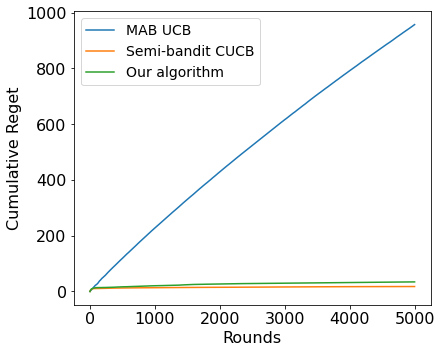

In [6]:
import matplotlib.pyplot as plt
regrets_b = np.cumsum(res_b, axis = 1)
regrets_m = np.cumsum(res_m, axis = 1)
regrets_s = np.cumsum(res_s, axis = 1)
mean_regrets_b = np.mean(regrets_b, axis = 0)
mean_regrets_m = np.mean(regrets_m, axis = 0)
mean_regrets_s = np.mean(regrets_s, axis = 0)
plt.figure(figsize=(6.4, 5.4))
plt.plot(mean_regrets_b, label = 'MAB UCB')
plt.plot(mean_regrets_s, label = 'Semi-bandit CUCB')
plt.plot(mean_regrets_m, label = 'Our algorithm')
# add legends
plt.legend(fontsize=14, loc=2)
plt.ylabel("Cumulative Reget", fontsize= 16)
plt.xlabel("Rounds", fontsize= 16)
plt.yticks(fontsize = 16)
plt.xticks(fontsize= 16)
plt.show()

**CI version**  
code for regret plots with CI bounds.

In [ ]:
from scipy.stats import sem, t
from scipy import mean
conf = 0.9
regrets_s = np.cumsum(res_b, axis = 1)
regrets_m = np.cumsum(res_m, axis = 1)
mean_regrets_b = np.mean(regrets_b, axis = 0)
mean_regrets_m = np.mean(regrets_m, axis = 0)
std_regrets_b = np.std(regrets_b, axis = 0)
std_regrets_m = np.std(regrets_m, axis = 0)
cin_b = t.ppf((1 + conf) / 2, number_of_ite - 1)/np.sqrt(number_of_ite)*std_regrets_b
cin_m = t.ppf((1 + conf) / 2, number_of_ite - 1)/np.sqrt(number_of_ite)*std_regrets_m

In [ ]:
import matplotlib.pyplot as plt
nn = np.linspace(0, 5000,5000)
plt.figure(figsize=(6.4, 4.8))
plt.plot(nn, mean_regrets_b, label = 'Benchmark')
plt.plot(mean_regrets_b-cin_b)
plt.fill_between(nn,mean_regrets_b-cin_b, mean_regrets_b+cin_b, alpha=0.1)
plt.plot(mean_regrets_m, label = 'Our algorithm')
plt.fill_between(nn,mean_regrets_m-cin_m, mean_regrets_m+cin_m, alpha=0.1)
# add legends
plt.legend(fontsize=14, loc=2)
plt.ylabel("Cumulative Reget", fontsize= 16)
plt.xlabel("Rounds", fontsize= 16)
plt.yticks(fontsize= 16)
plt.xticks(fontsize= 16)
plt.show()

In [ ]:
## Save results
import pickle
fname = 'Ld.pickle'
with open(fname, 'wb') as f:
    pickle.dump([res_s, res_m, res_b], f)